In [98]:
import sys
from os import listdir
import os

from xml.dom.minidom import parse

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.5.
The scikit-learn version is 0.20.1.


In [87]:
dir_train_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/MedLine/"
dir_train_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/DrugBank/"

In [88]:
dir_test_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/MedLine/"
dir_test_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/DrugBank/"

# Data

In [99]:
def parse_XML_file(datadir):
    trees = []
    for f in listdir(datadir):
        # parse XML file
        tree = parse(datadir + "/" + f)
        trees.append(tree)
    return trees

def extract_features(tokens) :
    # for each token, generate list of features and add it to the result
    result = []
    ps = PorterStemmer()
    for k in range(0,len(tokens)):
        tokenFeatures = {};
        
        t = tokens[k][0]
        tokenFeatures["form"] = t
        tokenFeatures["formlower"] = t.lower()
        tokenFeatures["suf3"] = t[-3:]
        tokenFeatures["suf4"] = t[-4:]
        tokenFeatures["isUpper"] = str(t.isupper())
        tokenFeatures["isTitle"] = str(t.istitle())
        tokenFeatures["isDigit"] = str(t.isdigit())
        tokenFeatures["isPlural"] = str(t[-1:] == 's')
        tokenFeatures["pos"] = nltk.pos_tag([t])[0][1]
        tokenFeatures["stem"] = ps.stem(t)

        if k>0 :
            tPrev = tokens[k-1][0]
            tokenFeatures["formPrev"] = tPrev
            tokenFeatures["formlowerPrev"] = tPrev.lower()
            tokenFeatures["suf3Prev"] = tPrev[-3:]
            tokenFeatures["suf4Prev"] = tPrev[-4:]
            tokenFeatures["isUpperPrev"] = str(tPrev.isupper())
            tokenFeatures["isTitlePrev"] = str(tPrev.istitle())
            tokenFeatures["isDigitPrev"] = str(tPrev.isdigit())
            tokenFeatures["isPluralPrev"] = str(tPrev[-1:] == 's')
            tokenFeatures["posPrev"] = nltk.pos_tag([tPrev])[0][1]
            tokenFeatures["stemPrev"] = ps.stem(tPrev)
            tokenFeatures["EoS"] = "False"
            tokenFeatures["BoS"] = "False"
        else :
            tokenFeatures["formPrev"] = ""
            tokenFeatures["formlowerPrev"] = ""
            tokenFeatures["suf3Prev"] = ""
            tokenFeatures["suf4Prev"] = ""
            tokenFeatures["isUpperPrev"] = ""
            tokenFeatures["isTitlePrev"] = ""
            tokenFeatures["isDigitPrev"] = ""
            tokenFeatures["isPluralPrev"] = ""
            tokenFeatures["posPrev"] = ""
            tokenFeatures["stemPrev"] = ""
            tokenFeatures["EoS"] = "False"
            tokenFeatures["BoS"] = "True"

        if k<len(tokens)-1 :
            tNext = tokens[k+1][0]
            tokenFeatures["formNext"] = tNext
            tokenFeatures["formlowerNext"] = tNext.lower()
            tokenFeatures["suf3Next"] = tNext[-3:]
            tokenFeatures["suf4Next"] = tNext[-4:]
            tokenFeatures["isUpperNext"] = str(tNext.isupper())
            tokenFeatures["isTitleNext"] = str(tNext.istitle())
            tokenFeatures["isDigitNext"] = str(tNext.isdigit())
            tokenFeatures["isPluralNext"] = str(tNext[-1:] == 's')
            tokenFeatures["posNext"] = nltk.pos_tag([tNext])[0][1]
            tokenFeatures["stemNext"] = ps.stem(tNext)
            tokenFeatures["EoS"] = "False"
            tokenFeatures["BoS"] = "False"
        else:
            tokenFeatures["formNext"] = ""
            tokenFeatures["formlowerNext"] = ""
            tokenFeatures["suf3Next"] = ""
            tokenFeatures["suf4Next"] = ""
            tokenFeatures["isUpperNext"] = ""
            tokenFeatures["isTitleNext"] = ""
            tokenFeatures["isDigitNext"] = ""
            tokenFeatures["isPluralNext"] = ""
            tokenFeatures["posNext"] = ""
            tokenFeatures["stemNext"] = ""
            tokenFeatures["EoS"] = "True"
            tokenFeatures["BoS"] = "False"
            
        result.append(tokenFeatures)

    return result

def tokenize(txt):
    offset = 0
    tks = []
    ## word_tokenize splits words, taking into account punctuations, numbers, etc.
    for t in word_tokenize(txt):
        ## keep track of the position where each token should appear, and
        ## store that information with the token
        offset = txt.find(t, offset)
        tks.append((t, offset, offset+len(t)-1))
        offset += len(t)

    ## tks is a list of triples (word,start,end)
    return tks

def get_tag(token, spans) :
    (form,start,end) = token
    for (spanS,spanE,spanT) in spans :
        if start==spanS and end<=spanE : return "B-"+spanT
        elif start>=spanS and end<=spanE : return "I-"+spanT
    return "O"

def process_trees(trees):
    items = []
    for tree in trees:
        # process each sentence in the file
        sentences = tree.getElementsByTagName("sentence")
        for s in sentences :
            sid = s.attributes["id"].value   # get sentence id
            spans = []
            stext = s.attributes["text"].value   # get sentence text
            entities = s.getElementsByTagName("entity")
            for e in entities :
                # for discontinuous entities, we only get the first span
                # (will not work, but there are few of them)
                (start,end) = e.attributes["charOffset"].value.split(";")[0].split("-")
                typ =  e.attributes["type"].value
                spans.append((int(start),int(end),typ))

        # convert the sentence to a list of tokens
        tokens = tokenize(stext)
        # extract sentence features
        features = extract_features(tokens)

        # print features in format expected by crfsuite trainer
        for i in range (0,len(tokens)) :
            # see if the token is part of an entity
            tag = get_tag(tokens[i], spans) 
            # print (sid, tokens[i][0], tokens[i][1], tokens[i][2], tag, "\t".join(features[i]), sep='\t')
            item = {"s_id": sid, "e_name": tokens[i][0], "e_type": tag, "e_off_s": tokens[i][1], "e_off_e": tokens[i][2]}
            item.update(features[i])
            items.append(item)
    
    return pd.DataFrame(items)

def load_data(datadir):
    trees = parse_XML_file(datadir)
    df_loaded = process_trees(trees)
    return df_loaded

## Train Data

In [100]:
df_train_drugbank = load_data(dir_train_drugbank)
df_train_drugbank.shape

(11914, 37)

In [101]:
df_train_medline = load_data(dir_train_medline)
df_train_medline.shape

(3550, 37)

In [102]:
df_train = df_train_drugbank.append(df_train_medline, ignore_index=True)
df_train.shape

(15464, 37)

In [103]:
# df_train.info()

In [104]:
df_train.head()

,BoS,EoS,e_name,e_off_e,e_off_s,e_type,form,formNext,formPrev,formlower,...,s_id,stem,stemNext,stemPrev,suf3,suf3Next,suf3Prev,suf4,suf4Next,suf4Prev
0,False,False,Milk,3,0,O,Milk,",",,milk,...,DDI-DrugBank.d481.s0,milk,",",,ilk,",",,Milk,",",
1,False,False,",",4,4,O,",",milk,Milk,",",...,DDI-DrugBank.d481.s0,",",milk,milk,",",ilk,ilk,",",milk,Milk
2,False,False,milk,9,6,O,milk,products,",",milk,...,DDI-DrugBank.d481.s0,milk,product,",",ilk,cts,",",milk,ucts,","
3,False,False,products,18,11,O,products,",",milk,products,...,DDI-DrugBank.d481.s0,product,",",milk,cts,",",ilk,ucts,",",milk
4,False,False,",",19,19,O,",",and,products,",",...,DDI-DrugBank.d481.s0,",",and,product,",",and,cts,",",and,ucts


## Test Data

In [105]:
df_test_drugbank = load_data(dir_test_drugbank)
df_test_drugbank.shape

(1118, 37)

In [106]:
df_test_medline = load_data(dir_test_medline)
df_test_medline.shape

(1392, 37)

# Input data

In [107]:
label = 'e_type'
not_features = ['e_name', 'e_off_e', 'e_off_s', 'e_type', 's_id']
features = [x for x in df_train.columns.tolist() if x not in not_features]
len(features)

32

In [108]:
def get_input(input_df, label_col, features_cols):
    Ys = np.array(input_df[label_col])
    Xs = np.array(input_df[features_cols])
    return Xs, Ys

In [109]:
X_train, Y_train = get_input(df_train, label, features)
X_test_drugbank, Y_test_drugbank = get_input(df_test_drugbank, label, features)
X_test_medline, Y_test_medline = get_input(df_test_medline, label, features)

### Encode training data

In [110]:
def encode_labels(Ys):
    le_Ys = preprocessing.LabelEncoder()
    le_Ys.fit(Ys)
    Ys_enc = le_Ys.transform(Ys)
    return Ys_enc, le_Ys

In [111]:
Y_train_enc, le = encode_labels(Y_train)
print("Classes:",le.classes_)

Classes: ['B-brand' 'B-drug' 'B-drug_n' 'B-group' 'I-brand' 'I-drug' 'I-drug_n'
 'I-group' 'O']


In [112]:
def encode_features(Xs):
    enc_Xs = preprocessing.OneHotEncoder(handle_unknown="ignore")
    enc_Xs.fit(Xs)
    Xs_enc = enc_Xs.transform(Xs)
    return Xs_enc, enc_Xs

In [113]:
X_train_enc, enc = encode_features(X_train)
print("Categories:", enc.categories_)

Categories: [array(['False'], dtype=object), array(['False', 'True'], dtype=object), array(['%', "'s", '(', ..., 'zidovudine', 'zinc', 'zinc-chelating'],
      dtype=object), array(['', '%', "'s", ..., 'zidovudine', 'zinc', 'zinc-chelating'],
      dtype=object), array(['', '%', "'s", ..., 'zidovudine', 'zinc', 'zinc-chelating'],
      dtype=object), array(['%', "'s", '(', ..., 'zinc-chelating', 'zmax', 'zoladex'],
      dtype=object), array(['', '%', "'s", ..., 'zinc-chelating', 'zmax', 'zoladex'],
      dtype=object), array(['', '%', "'s", ..., 'zinc-chelating', 'zmax', 'zoladex'],
      dtype=object), array(['False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), array(['False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), array(['False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), array(['', 'False', 'True'], dtype=object), arra

### Encode testing data

In [114]:
Y_test_drugbank_enc = le.transform(Y_test_drugbank)
X_test_drugbank_enc = enc.transform(X_test_drugbank)
print(Y_test_drugbank_enc.shape, X_test_drugbank_enc.shape)

(1118,) (1118, 34702)


In [115]:
Y_test_medline_enc = le.transform(Y_test_medline)
X_test_medline_enc = enc.transform(X_test_medline)
print(Y_test_medline_enc.shape, X_test_medline_enc.shape)

(1392,) (1392, 34702)


# Model

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [117]:
clf_tree = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

### Model optimization

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
param_grid_tree = [
  {'max_depth': [100, 1000, None]},
 ]

param_grid_rf = [
  {'max_depth': [100, 1000, None], 'n_estimators': [100, 200, 300]},
 ]

In [120]:
#clf = GridSearchCV(clf_rf, param_grid_rf, cv=3)
clf = RandomForestClassifier(random_state=42, max_depth=1000, n_estimators=200)
clf.fit(X_train_enc, Y_train_enc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [158]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 1000, 'n_estimators': 200}

Grid scores on development set:

0.933 (+/-0.010) for {'max_depth': 100, 'n_estimators': 100}
0.933 (+/-0.009) for {'max_depth': 100, 'n_estimators': 200}
0.933 (+/-0.010) for {'max_depth': 100, 'n_estimators': 300}
0.935 (+/-0.010) for {'max_depth': 1000, 'n_estimators': 100}
0.936 (+/-0.009) for {'max_depth': 1000, 'n_estimators': 200}
0.935 (+/-0.010) for {'max_depth': 1000, 'n_estimators': 300}
0.935 (+/-0.010) for {'max_depth': None, 'n_estimators': 100}
0.936 (+/-0.009) for {'max_depth': None, 'n_estimators': 200}
0.935 (+/-0.010) for {'max_depth': None, 'n_estimators': 300}


## Classification

In [121]:
Y_pred_drugbank = clf.predict(X_test_drugbank_enc)
Y_pred_medline = clf.predict(X_test_medline_enc)

In [122]:
print("DrugBank score:")
clf.score(X_test_drugbank_enc, Y_test_drugbank_enc)

DrugBank score:


0.9230769230769231

In [123]:
print("MedLine score:")
clf.score(X_test_medline_enc, Y_test_medline_enc)

MedLine score:


0.9647988505747126

In [124]:
from sklearn.metrics import classification_report
print("DrugBank classification report:")
print(classification_report(Y_test_drugbank_enc, Y_pred_drugbank))

DrugBank classification report:
              precision    recall  f1-score   support

           0       0.71      0.24      0.36        21
           1       0.83      0.68      0.75        79
           2       0.00      0.00      0.00         4
           3       0.79      0.42      0.55        26
           4       0.00      0.00      0.00         1
           5       1.00      0.14      0.25         7
           6       0.00      0.00      0.00         5
           7       0.93      0.68      0.79        19
           8       0.93      0.99      0.96       956

   micro avg       0.92      0.92      0.92      1118
   macro avg       0.58      0.35      0.41      1118
weighted avg       0.91      0.92      0.91      1118



/Users/lluccardoner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
print("MedLine classification report:")
print(classification_report(Y_test_medline_enc, Y_pred_medline))

MedLine classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.35      0.38      0.36        16
           2       0.00      0.00      0.00         8
           3       0.75      0.18      0.29        17
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       1.00      0.50      0.67         8
           8       0.97      0.99      0.98      1338

   micro avg       0.96      0.96      0.96      1392
   macro avg       0.51      0.30      0.35      1392
weighted avg       0.96      0.96      0.96      1392



/Users/lluccardoner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lluccardoner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Confusion matrix

In [126]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [127]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


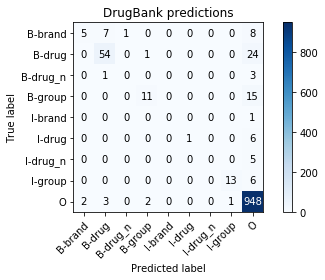

In [128]:
class_names = le.classes_
plot_confusion_matrix(Y_test_drugbank_enc, Y_pred_drugbank, classes=class_names, title="DrugBank predictions")
plt.show()

Confusion matrix, without normalization


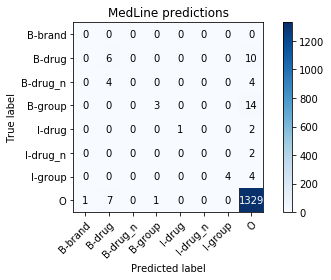

In [129]:
class_names = le.classes_
plot_confusion_matrix(Y_test_medline_enc, Y_pred_medline, classes=class_names, title="MedLine predictions")
plt.show()

## Detection and classification

In [130]:
def predict(input_features):
    X = np.array(input_features)
    encoded = enc.transform([X])
    prediction = clf.predict(encoded)
    label = le.inverse_transform(prediction)[0]
    return label

In [131]:
print("Drop label column: ", label)
data_drugbank = df_test_drugbank.drop(label, axis=1)
data_drugbank['pred'] = data_drugbank[features].apply(lambda row: predict(row), axis=1)
data_drugbank.head()

Drop label column:  e_type


,BoS,EoS,e_name,e_off_e,e_off_s,form,formNext,formPrev,formlower,formlowerNext,...,stem,stemNext,stemPrev,suf3,suf3Next,suf3Prev,suf4,suf4Next,suf4Prev,pred
0,False,False,There,4,0,There,are,,there,are,...,there,are,,ere,are,,here,are,,O
1,False,False,are,8,6,are,",",There,are,",",...,are,",",there,are,",",ere,are,",",here,O
2,False,False,",",9,9,",",as,are,",",as,...,",",as,are,",",as,are,",",as,are,O
3,False,False,as,12,11,as,yet,",",as,yet,...,as,yet,",",as,yet,",",as,yet,",",O
4,False,False,yet,16,14,yet,",",as,yet,",",...,yet,",",as,yet,",",as,yet,",",as,O


In [132]:
print("Drop label column: ", label)
data_medline = df_test_medline.drop(label, axis=1)
data_medline['pred'] = data_medline[features].apply(lambda row: predict(row), axis=1)
data_medline.head()

Drop label column:  e_type


,BoS,EoS,e_name,e_off_e,e_off_s,form,formNext,formPrev,formlower,formlowerNext,...,stem,stemNext,stemPrev,suf3,suf3Next,suf3Prev,suf4,suf4Next,suf4Prev,pred
0,False,False,Future,5,0,Future,studies,,future,studies,...,futur,studi,,ure,ies,,ture,dies,,O
1,False,False,studies,13,7,studies,are,Future,studies,are,...,studi,are,futur,ies,are,ure,dies,are,ture,O
2,False,False,are,17,15,are,needed,studies,are,needed,...,are,need,studi,are,ded,ies,are,eded,dies,O
3,False,False,needed,24,19,needed,to,are,needed,to,...,need,to,are,ded,to,are,eded,to,are,O
4,False,False,to,27,26,to,examine,needed,to,examine,...,to,examin,need,to,ine,ded,to,mine,eded,O


In [133]:
def instances(data_df):
    xseq = []
    toks = []
    s_id = None
    
    for index, row in data_df.iterrows():
        if s_id is None:
            s_id = row['s_id']
        
        row_sid = row['s_id']
        if not s_id == row_sid:
            # Return accumulated sequences, and reinitialize.
            yield xseq, toks
            xseq = []
            toks = []
            xseq.append(row['pred'])
            toks.append(row[['s_id', 'e_name', 'e_off_s', 'e_off_e']])
            continue
    
        xseq.append(row['pred'])
        toks.append(row[['s_id', 'e_name', 'e_off_s', 'e_off_e']])

In [140]:
def multi_token_prediction(data_df, text_file):
    for predictions,toks in instances(data_drugbank):
        inside = False;
        for k in range(0,len(predictions)) :
            y = predictions[k]
            (sid, form, offS, offE) = toks[k]
            offS = str(offS)
            offE = str(offE)
            
            if (y[0]=="B") :
                entity_form = form
                entity_start = offS
                entity_end = offE
                entity_type = y[2:]
                inside = True
            elif (y[0]=="I" and inside) :
                entity_form += " "+form
                entity_end = offE
            elif (y[0]=="O" and inside) :
                print(sid, entity_start+"-"+entity_end, entity_form, entity_type, sep="|", file=text_file)
                inside = False

        if inside : print(sid, entity_start+"-"+entity_end, entity_form, entity_type, sep="|", file=text_file)

In [139]:
multi_token_prediction(data_medline, None)

nervous I-group
system I-group
( I-group
CNS I-group
) I-group
depressants I-group
antidepressants I-group
channel I-group
depressants I-group
antidepressants I-group
agents I-group
antibodies I-group
channel I-group
Sulfate I-drug
inhibitors I-group


In [172]:
def save_output(data_df, file_name):
    with open(file_name, "w") as text_file:
        multi_token_prediction(data_df, text_file)

In [173]:
save_output(data_medline, "task9.1_TREE1_medline_3.txt")
save_output(data_drugbank, "task9.1_TREE1_drugbank_3.txt")